# CLIP 混淆案例分析

本notebook专注于分析CLIP在分类时容易混淆的类别对，并通过改进prompts来提升分类效果。

主要步骤：
1. 导入必要的库和加载模型
2. 准备数据集
3. 实现混淆分析函数
4. 测试不同的prompts策略
5. 分析结果

In [1]:
import torch
import open_clip
from PIL import Image
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

# 设置设备
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# 加载模型
model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='openai')
model = model.to(device)
model.eval()

Using device: cuda


CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (patch_dropout): Identity()
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): ModuleList(
        (0): ResidualAttentionBlock(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ls_1): Identity()
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ls_2): Identity()
        )
        (1): ResidualAttentionBlock(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_a

In [2]:
# 准备数据集
def prepare_datasets():
    # Food101数据集
    food101_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    food101_test = datasets.Food101(
        root='./data',
        split='test',
        transform=food101_transform,
        download=True
    )
    
    food_loader = DataLoader(
        food101_test,
        batch_size=32,
        shuffle=False,
        num_workers=4
    )
    
    return food101_test, food_loader

# 加载数据集
food101_test, food_loader = prepare_datasets()

In [3]:
# 分析特定的混淆对
def analyze_confusion_pair(model, loader, class1, class2, device, n_samples=5):
    """分析特定的混淆类别对，使用不同的prompt策略"""
    # 基础prompts
    basic_prompts = [
        f"a photo of a {class1}",
        f"a photo of a {class2}"
    ]
    
    # 详细prompts - 添加更多描述性特征
    detailed_prompts = [
        f"a clear photo of a {class1}, showing its distinctive features and characteristics",
        f"a clear photo of a {class2}, showing its distinctive features and characteristics"
    ]
    
    # 特定特征prompts - 根据具体类别添加
    specific_prompts = get_specific_prompts(class1, class2)
    
    # 收集样本并测试
    examples_found = 0
    results = []
    
    for images, labels in loader:
        if examples_found >= n_samples:
            break
            
        images = images.to(device)
        with torch.no_grad():
            # 测试所有prompts
            for i, (image, label) in enumerate(zip(images, labels)):
                if label == class1 and examples_found < n_samples:
                    example_results = {}
                    image_input = image.unsqueeze(0)
                    
                    for prompt_name, prompts in [
                        ("basic", basic_prompts),
                        ("detailed", detailed_prompts),
                        ("specific", specific_prompts)
                    ]:
                        text = open_clip.tokenize(prompts).to(device)
                        image_features = model.encode_image(image_input)
                        text_features = model.encode_text(text)
                        
                        # 计算相似度
                        image_features /= image_features.norm(dim=-1, keepdim=True)
                        text_features /= text_features.norm(dim=-1, keepdim=True)
                        similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
                        
                        example_results[prompt_name] = similarity[0].cpu().numpy()
                    
                    results.append(example_results)
                    examples_found += 1
    
    return results

def get_specific_prompts(class1, class2):
    """获取特定类别的详细prompts"""
    prompts_dict = {
        ('caesar_salad', 'peking_duck'): [
            "a photo of a caesar salad with fresh green lettuce, croutons, parmesan cheese, and creamy dressing",
            "a photo of a peking duck with crispy brown skin, served with thin pancakes and hoisin sauce"
        ],
        ('poutine', 'peking_duck'): [
            "a photo of poutine with crispy french fries covered in brown gravy and melted cheese curds",
            "a photo of a peking duck with crispy brown skin, served with thin pancakes and hoisin sauce"
        ]
    }
    
    return prompts_dict.get((class1, class2), [
        f"a detailed photo of {class1}",
        f"a detailed photo of {class2}"
    ])


分析混淆对: caesar_salad vs peking_duck


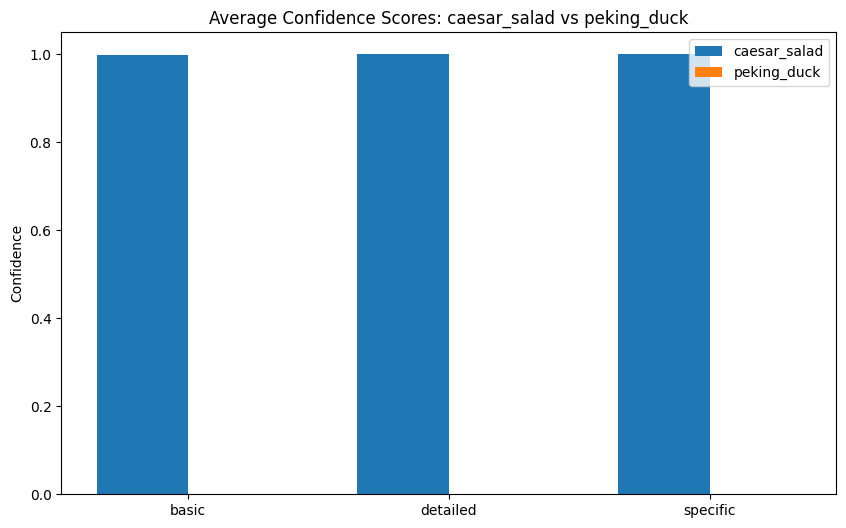


Basic Prompts 平均结果:
  caesar_salad: 99.94%
  peking_duck: 0.06%

Detailed Prompts 平均结果:
  caesar_salad: 100.00%
  peking_duck: 0.00%

Specific Prompts 平均结果:
  caesar_salad: 100.00%
  peking_duck: 0.00%

分析混淆对: poutine vs peking_duck


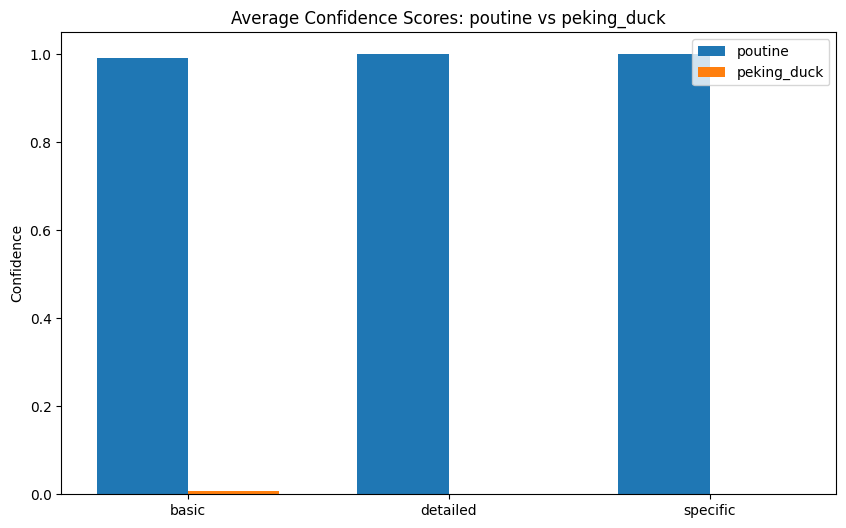


Basic Prompts 平均结果:
  poutine: 99.23%
  peking_duck: 0.77%

Detailed Prompts 平均结果:
  poutine: 99.99%
  peking_duck: 0.01%

Specific Prompts 平均结果:
  poutine: 99.98%
  peking_duck: 0.02%


In [6]:
# 测试混淆对并可视化结果
def analyze_and_visualize_confusion(model, class1, class2, device, n_samples=32):  # 增加样本数量
    print(f"\n分析混淆对: {class1} vs {class2}")
    
    # 准备数据集
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    dataset = datasets.Food101(
        root='./data',
        split='test',
        transform=transform,
        download=True
    )
    
    # 只选择相关类别的数据
    indices = [i for i, (_, label) in enumerate(dataset) 
              if dataset.classes[label] in [class1, class2]][:n_samples]
    subset = torch.utils.data.Subset(dataset, indices)
    
    loader = DataLoader(
        subset,
        batch_size=32,  # 增大batch size
        shuffle=True,
        num_workers=4,  # 使用4个工作线程
        pin_memory=True  # 启用pin_memory加速数据传输
    )
    
    # 准备不同的prompts
    basic_prompts = [
        f"a photo of a {class1}",
        f"a photo of a {class2}"
    ]
    
    detailed_prompts = [
        f"a clear photo of a {class1}, showing its distinctive features",
        f"a clear photo of a {class2}, showing its distinctive features"
    ]
    
    specific_prompts = get_specific_prompts(class1, class2)
    
    # 预计算所有text features
    with torch.cuda.amp.autocast():  # 使用混合精度
        with torch.no_grad():
            text_features_dict = {}
            for prompt_name, prompts in [
                ("basic", basic_prompts),
                ("detailed", detailed_prompts),
                ("specific", specific_prompts)
            ]:
                text = open_clip.tokenize(prompts).to(device)
                text_features = model.encode_text(text)
                text_features = text_features / text_features.norm(dim=-1, keepdim=True)
                text_features_dict[prompt_name] = text_features
    
    results = []
    # 收集结果
    with torch.cuda.amp.autocast():  # 使用混合精度
        with torch.no_grad():
            for images, _ in loader:
                images = images.to(device)
                batch_results = []
                
                # 一次性计算整个batch的image features
                image_features = model.encode_image(images)
                image_features = image_features / image_features.norm(dim=-1, keepdim=True)
                
                for i in range(len(images)):
                    example_results = {}
                    img_feat = image_features[i:i+1]
                    
                    for prompt_name in ["basic", "detailed", "specific"]:
                        text_features = text_features_dict[prompt_name]
                        similarity = (100.0 * img_feat @ text_features.T).softmax(dim=-1)
                        example_results[prompt_name] = similarity[0].cpu().numpy()
                    
                    results.append(example_results)
    
    # 计算平均结果
    avg_results = {
        prompt_type: np.mean([r[prompt_type] for r in results], axis=0)
        for prompt_type in ['basic', 'detailed', 'specific']
    }
    
    # 绘制结果
    prompt_types = ['basic', 'detailed', 'specific']
    x = np.arange(len(prompt_types))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width/2, [avg_results[pt][0] for pt in prompt_types], width, label=class1)
    rects2 = ax.bar(x + width/2, [avg_results[pt][1] for pt in prompt_types], width, label=class2)
    
    ax.set_ylabel('Confidence')
    ax.set_title(f'Average Confidence Scores: {class1} vs {class2}')
    ax.set_xticks(x)
    ax.set_xticklabels(prompt_types)
    ax.legend()
    
    plt.show()
    
    # 打印详细结果
    for prompt_type in prompt_types:
        print(f"\n{prompt_type.capitalize()} Prompts 平均结果:")
        print(f"  {class1}: {avg_results[prompt_type][0]:.2%}")
        print(f"  {class2}: {avg_results[prompt_type][1]:.2%}")

# 分析常见的混淆对
confused_pairs = [
    ('caesar_salad', 'peking_duck'),
    ('poutine', 'peking_duck')
]

# 运行分析
for class1, class2 in confused_pairs:
    analyze_and_visualize_confusion(model, class1, class2, device)

In [17]:
def find_confusing_pairs(model, device, n_samples=30, n_classes=20, threshold=0.25):
    """增加样本数和类别数，并改进分析方法"""
    print("开始分析混淆对...")
    
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    print("加载数据集...")
    dataset = datasets.Food101(
        root='./data',
        split='test',
        transform=transform,
        download=True
    )
    
    # 修改类别组，确保所有类别都在Food101数据集中
    related_categories = [
        # 肉类（细分）
        ['steak', 'prime_rib', 'pork_chop', 'baby_back_ribs'],
        # 海鲜
        ['sushi', 'fish_and_chips', 'mussels', 'lobster_roll_sandwich'],
        # 意大利面/通心粉
        ['spaghetti_bolognese', 'lasagna', 'ravioli', 'macaroni_and_cheese'],
        # 亚洲食品
        ['pad_thai', 'spring_rolls', 'edamame', 'gyoza'],
        # 沙拉
        ['caesar_salad', 'greek_salad', 'caprese_salad', 'seaweed_salad'],
        # 汤
        ['french_onion_soup', 'clam_chowder', 'miso_soup', 'hot_and_sour_soup', 'lobster_bisque'],
        # 甜点
        ['chocolate_cake', 'cheesecake', 'carrot_cake', 'apple_pie', 'ice_cream'],
        # 快餐
        ['hamburger', 'french_fries', 'chicken_wings', 'onion_rings']
    ]
    
    # 验证所有类别名称
    all_classes = set(dataset.classes)
    valid_categories = []
    for category_group in related_categories:
        valid_group = [cls for cls in category_group if cls in all_classes]
        if valid_group:  # 只添加非空组
            valid_categories.append(valid_group)
    
    print("\n有效的类别组:")
    for i, group in enumerate(valid_categories):
        print(f"组 {i+1}: {', '.join(group)}")
    
    # 从每个组选择类别
    selected_classes = []
    n_per_group = max(2, n_classes // len(valid_categories))
    for category_group in valid_categories:
        n_select = min(n_per_group, len(category_group))
        selected = np.random.choice(category_group, n_select, replace=False)
        selected_classes.extend(selected)
    
    # 如果需要更多类别，从所有组中随机选择
    if len(selected_classes) < n_classes:
        remaining_classes = list(set([cls for group in valid_categories for cls in group]) - set(selected_classes))
        if remaining_classes:
            additional = np.random.choice(remaining_classes, 
                                        min(n_classes - len(selected_classes), len(remaining_classes)), 
                                        replace=False)
            selected_classes.extend(additional)
    
    print(f"\n选择的类别 (共{len(selected_classes)}个):")
    for i, cls in enumerate(selected_classes):
        print(f"  {i+1}. {cls}")
    
    print("\n预计算text features...")
    all_prompts = [f"a photo of {cls.replace('_', ' ')}" for cls in selected_classes]
    with torch.cuda.amp.autocast():
        with torch.no_grad():
            text = open_clip.tokenize(all_prompts).to(device)
            text_features = model.encode_text(text)
            text_features = text_features / text_features.norm(dim=-1, keepdim=True)
    
    confusion_stats = {}
    
    print("准备数据...")
    samples_per_class = {}
    for class_name in selected_classes:
        class_idx = dataset.classes.index(class_name)
        class_samples = [i for i in range(len(dataset)) if dataset._labels[i] == class_idx]
        if len(class_samples) > n_samples:
            class_samples = np.random.choice(class_samples, n_samples, replace=False)
        samples_per_class[class_name] = class_samples
    
    # ... 后面的代码保持不变 ...
    # 修改类别组，增加更多细粒度的相似类别
    related_categories = [
        # 肉类（细分）
        ['steak', 'prime_rib', 'pork_chop', 'baby_back_ribs', 'beef_carpaccio'],
        # 海鲜（生食）
        ['sushi', 'sashimi', 'ceviche', 'tuna_tartare', 'oysters'],
        # 海鲜（熟食）
        ['fish_and_chips', 'mussels', 'lobster_roll_sandwich', 'fried_calamari', 'grilled_salmon'],
        # 意大利面/通心粉
        ['spaghetti_bolognese', 'lasagna', 'ravioli', 'macaroni_and_cheese', 'fettuccine_alfredo'],
        # 亚洲面食
        ['pad_thai', 'ramen', 'pho', 'spring_rolls', 'dumplings'],
        # 沙拉
        ['caesar_salad', 'greek_salad', 'caprese_salad', 'edamame', 'seaweed_salad'],
        # 汤
        ['french_onion_soup', 'clam_chowder', 'miso_soup', 'hot_and_sour_soup', 'lobster_bisque'],
        # 甜点（蛋糕类）
        ['chocolate_cake', 'cheesecake', 'carrot_cake', 'tiramisu', 'red_velvet_cake']
    ]
    

    # 改进混淆分析逻辑
    def analyze_confusion(similarity_matrix, confidence_threshold=0.3):
        values, indices = similarity_matrix.topk(3, dim=1)  # 获取top3预测
        confusion_results = []
        
        for i in range(len(values)):
            # 检查top2和top3的预测，排除自身
            true_class_idx = indices[i][0]
            for k in range(1, 3):
                pred_class_idx = indices[i][k]
                if pred_class_idx != true_class_idx and values[i][k] > confidence_threshold:
                    confusion_results.append({
                        'true_idx': true_class_idx,
                        'pred_idx': pred_class_idx,
                        'confidence': float(values[i][k]),
                        'confidence_gap': float(values[i][0] - values[i][k])
                    })
        return confusion_results
    
    # 在主循环中收集更详细的统计信息
    for class_name, indices in samples_per_class.items():
        print(f"\n分析类别: {class_name}")
        
        subset = torch.utils.data.Subset(dataset, indices)
        loader = DataLoader(
            subset,
            batch_size=min(n_samples, 32),
            num_workers=4,
            pin_memory=True
        )
        
        class_confusion = {}
        total_samples = 0
        all_predictions = []  # 收集所有预测结果
        
        with torch.cuda.amp.autocast():
            with torch.no_grad():
                for images, _ in loader:
                    images = images.to(device)
                    image_features = model.encode_image(images)
                    image_features = image_features / image_features.norm(dim=-1, keepdim=True)
                    similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
                    
                    # 收集所有预测结果
                    values, indices = similarity.topk(3, dim=1)
                    for i in range(len(values)):
                        all_predictions.append({
                            'true_class': class_name,
                            'pred_classes': [selected_classes[idx] for idx in indices[i]],
                            'confidences': [float(val) for val in values[i]]
                        })
                    
                    confusion_results = analyze_confusion(similarity, threshold)
                    total_samples += len(images)
                    
                    for result in confusion_results:
                        confused_class = selected_classes[result['pred_idx']]
                        if confused_class not in class_confusion:
                            class_confusion[confused_class] = {
                                'count': 0,
                                'avg_confidence': 0.0,
                                'confidence_gaps': [],
                                'confidences': [],
                                'examples': []  # 存储具体的混淆例子
                            }
                        
                        stats = class_confusion[confused_class]
                        stats['count'] += 1
                        stats['avg_confidence'] += result['confidence']
                        stats['confidence_gaps'].append(result['confidence_gap'])
                        stats['confidences'].append(result['confidence'])
                        if len(stats['examples']) < 5:  # 只保存前5个例子
                            stats['examples'].append({
                                'confidence': result['confidence'],
                                'confidence_gap': result['confidence_gap']
                            })
        
        # 计算更详细的统计信息
        for confused_class in class_confusion:
            stats = class_confusion[confused_class]
            if stats['count'] > 0:
                stats['avg_confidence'] /= stats['count']
                stats['confusion_rate'] = stats['count'] / total_samples
                stats['avg_confidence_gap'] = np.mean(stats['confidence_gaps'])
                stats['std_confidence'] = np.std(stats['confidences'])
                
                # 使用更复杂的条件来判断显著混淆
                is_significant = (
                    stats['confusion_rate'] >= 0.15 and  # 降低混淆率阈值
                    stats['avg_confidence'] >= 0.25 and  # 降低平均置信度要求
                    stats['avg_confidence_gap'] <= 0.5   # 增加允许的置信度差距
                )
                
                if is_significant:
                    if class_name not in confusion_stats:
                        confusion_stats[class_name] = {}
                    confusion_stats[class_name][confused_class] = stats
                    print(f"发现显著混淆类别: {confused_class}")
                    print(f"  混淆率: {stats['confusion_rate']:.2%}")
                    print(f"  平均置信度: {stats['avg_confidence']:.2%}")
                    print(f"  置信度标准差: {stats['std_confidence']:.2%}")
                    print(f"  平均置信度差距: {stats['avg_confidence_gap']:.2%}")
                    print("  混淆例子:")
                    for i, example in enumerate(stats['examples'], 1):
                        print(f"    例{i}: 置信度={example['confidence']:.2%}, 差距={example['confidence_gap']:.2%}")
    
    return confusion_stats, all_predictions

# 运行改进后的分析
confusion_stats, all_predictions = find_confusing_pairs(
    model, 
    device,
    n_samples=30,    # 保持样本数
    n_classes=20,    # 保持类别数
    threshold=0.25   # 保持阈值
)

开始分析混淆对...
加载数据集...

有效的类别组:
组 1: steak, prime_rib, pork_chop, baby_back_ribs
组 2: sushi, fish_and_chips, mussels, lobster_roll_sandwich
组 3: spaghetti_bolognese, lasagna, ravioli, macaroni_and_cheese
组 4: pad_thai, spring_rolls, edamame, gyoza
组 5: caesar_salad, greek_salad, caprese_salad, seaweed_salad
组 6: french_onion_soup, clam_chowder, miso_soup, hot_and_sour_soup, lobster_bisque
组 7: chocolate_cake, cheesecake, carrot_cake, apple_pie, ice_cream
组 8: hamburger, french_fries, chicken_wings, onion_rings

选择的类别 (共20个):
  1. pork_chop
  2. prime_rib
  3. sushi
  4. mussels
  5. lasagna
  6. macaroni_and_cheese
  7. edamame
  8. gyoza
  9. caesar_salad
  10. greek_salad
  11. clam_chowder
  12. lobster_bisque
  13. cheesecake
  14. chocolate_cake
  15. chicken_wings
  16. onion_rings
  17. hot_and_sour_soup
  18. steak
  19. pad_thai
  20. miso_soup

预计算text features...
准备数据...

分析类别: pork_chop
发现显著混淆类别: steak
  混淆率: 16.67%
  平均置信度: 35.85%
  置信度标准差: 4.72%
  平均置信度差距: 17.12%
  混淆例子:
   